In [1]:
#imports 
import matplotlib
import mplcursors
import numpy as np
import matplotlib.pyplot as plt
import json
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import os

/home/guillaumelevy/Documents/WorldLLM/.venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
# Load the data
shared_extension = ""
baselines_to_load = [
    "playground_metropolis_pb",
    "playground_metropolis_phi_phi",
    "playground_metropolis_rb",
    "playground_metropolis_cp",
]
baselines_names = ["M PB", "M 1it", "M RB", "M CP"]
all_data = {k: [] for k in baselines_names}
all_rules = {}
all_likelihoods = {}
all_weights = {}
all_additional_data = {}
for baseline, b_name in zip(baselines_to_load, baselines_names):
    print(
        "-------------------------------- Load "
        + baseline
        + " --------------------------------"
    )
    path_start = "./outputs/" + baseline + shared_extension + "/"
    lst_data = []
    for f_day in os.listdir(path_start):
        if os.path.isdir(path_start + f_day):
            for f_hour in os.listdir(path_start + f_day):
                if os.path.isdir(path_start + f_day + "/" + f_hour):
                    path = path_start + f_day + "/" + f_hour + "/all.json"
                    with open(path, "r") as file:
                        lst_data.append(json.load(file))
                        print("Loaded: " + path)
    # Reconstruct all rules and parse by seeds
    if "counts" in lst_data[0]["metrics"]:
        # Parse IS
        rules = []
        likelihoods = []
        weights = []
        for data in lst_data:
            rules.append(np.repeat(data["rules"], data["metrics"]["counts"]))
            likelihoods.append(
                np.repeat(
                    data["metrics"]["test_likelihoods"], data["metrics"]["counts"]
                )
            )
            weights.append(
                np.repeat(data["metrics"]["weights"], data["metrics"]["counts"])
            )
        all_rules[b_name] = np.stack(rules)
        all_likelihoods[b_name] = np.stack(likelihoods)
        all_weights[b_name] = np.stack(weights)
    elif "prev_rules_ind" in lst_data[0]["metrics"]:
        # Parse Metropolis
        # Reconstruct all rules M
        reshaped_rules = []
        reshaped_likelihoods = []
        reshaped_weights = []
        reshaped_prev_rules_ind = []
        for data in lst_data:
            # TODO: remove hardcoded default rule to 3
            nb_particles = (
                data["metrics"]["nb_rules"] if "nb_rules" in data["metrics"] else 3
            )
            rules = np.array(data["rules"])
            likelihoods = np.array(data["metrics"]["test_likelihoods"])
            weights = np.array(data["metrics"]["weights"])
            prev_rules_ind = np.array(data["metrics"]["prev_rules_ind"])
            reshaped_rules.append(rules.reshape((-1, nb_particles)).transpose())
            reshaped_likelihoods.append(
                likelihoods.reshape((-1, nb_particles)).transpose()
            )
            reshaped_weights.append(weights.reshape((-1, nb_particles)).transpose())
            reshaped_prev_rules_ind.append(
                prev_rules_ind.reshape((-1, nb_particles)).transpose()
            )
        # Concatenate all seeds
        all_rules[b_name] = np.concatenate(reshaped_rules, axis=0)
        all_likelihoods[b_name] = np.concatenate(reshaped_likelihoods, axis=0)
        all_weights[b_name] = np.concatenate(reshaped_weights, axis=0)
        all_additional_data[b_name] = {
            "prev_rules_ind": np.concatenate(reshaped_prev_rules_ind, axis=0)
        }
    else:
        raise ValueError("Unknown format")
    all_data[b_name] = lst_data

-------------------------------- Load playground_metropolis_pb --------------------------------
Loaded: ./outputs/playground_metropolis_pb/2024-09-13/20-06-49_439/all.json
Loaded: ./outputs/playground_metropolis_pb/2024-09-13/20-06-47_438/all.json
-------------------------------- Load playground_metropolis_phi_phi --------------------------------
Loaded: ./outputs/playground_metropolis_phi_phi/2024-09-13/20-06-48_438/all.json
Loaded: ./outputs/playground_metropolis_phi_phi/2024-09-13/20-06-47_439/all.json
-------------------------------- Load playground_metropolis_rb --------------------------------
Loaded: ./outputs/playground_metropolis_rb/2024-09-13/20-06-46_440/all.json
Loaded: ./outputs/playground_metropolis_rb/2024-09-13/20-06-46_441/all.json
-------------------------------- Load playground_metropolis_cp --------------------------------
Loaded: ./outputs/playground_metropolis_cp/2024-09-13/20-06-47_443/all.json
Loaded: ./outputs/playground_metropolis_cp/2024-09-13/20-06-46_442/al

In [3]:
# Compare best rule for IS and M
# Best rules of each method
best_taken = 50
all_baselines_name = list(all_likelihoods.keys())
all_best_rules_ind = []
for b_name in all_baselines_name:
    best_rules_ind = np.argsort(-all_likelihoods[b_name].flatten())[:best_taken]
    all_best_rules_ind.append(best_rules_ind)
likelihoods = np.concatenate([all_likelihoods[b_name].flatten()[all_best_rules_ind[incr]] for incr, b_name in enumerate(all_baselines_name)])
rules = np.concatenate([all_rules[b_name].flatten()[all_best_rules_ind[incr]] for incr, b_name in enumerate(all_baselines_name)])
indices = np.argsort(-likelihoods)
all_colors_start = ["\033[31m", "\033[32m", "\033[34m", "\033[35m", "\033[36m", "\033[37m", "\033[33m", "\033[90m"]
all_colors_end = ["\033[0m"] * len(all_colors_start)
all_colors_names = ["Red", "Green", "Blue", "Magenta", "Cyan", "White", "Yellow", "Bright Black"]
# Print colors for every baselines:
print("Colors for each baselines:")
for incr, b_name in enumerate(all_baselines_name):
    print(f"Baseline: '{b_name}' Color: {all_colors_start[incr]}{all_colors_names[incr]}{all_colors_end[incr]}")
for incr, ind in enumerate(indices):
    color_start = all_colors_start[ind//best_taken]
    color_end = all_colors_end[ind//best_taken]
    print(
        f"{color_start}-----rule-----:{incr}: {repr(rules[ind])}, likelihood: {likelihoods[ind]:2f}{color_end}"
    )

Colors for each baselines:
Baseline: 'M PB' Color: Red
Baseline: 'M 1it' Color: Green
Baseline: 'M RB' Color: Blue
Baseline: 'M CP' Color: Magenta
-----rule-----:0: '1. Occupation Action: When an action involves going towards or occupying a specific entity (e.g., "a: You go to the baby giraffe. o: You are standing on the baby giraffe."), that specific entity takes the most recent host\'s action and becomes the new host.\n\n2. No Change Action: If an action has \'Nothing has changed\' associated with it or where hosting actions are not explicitly stated, all other specified entities remain unchanged, maintaining their last known state after sequential host changes.\n\n3. Combination Action: When an action involves picking up an object (e.g., "a: You pick up the object. o: You are holding the water and the berry seed."), the host selects changes to become a cumulative host for all specified entities, handling or containing all of them accordingly ("you are holding the water and the berry

In [4]:
# Number of sames rules per particle
for b_name in all_baselines_name:
    redudant_rules = [len(all_rules[b_name][particle])- len(set(all_rules[b_name][particle])) for particle in range(all_rules[b_name].shape[0])]
    print(f"Number of same rules per particle for {b_name}: {redudant_rules}")

Number of same rules per particle for M PB: [0, 0, 2, 2, 0, 0]
Number of same rules per particle for M 1it: [1, 0, 0, 5, 0, 1]
Number of same rules per particle for M RB: [0, 1, 0, 1, 1, 1]
Number of same rules per particle for M CP: [0, 7, 0, 0, 17, 1]


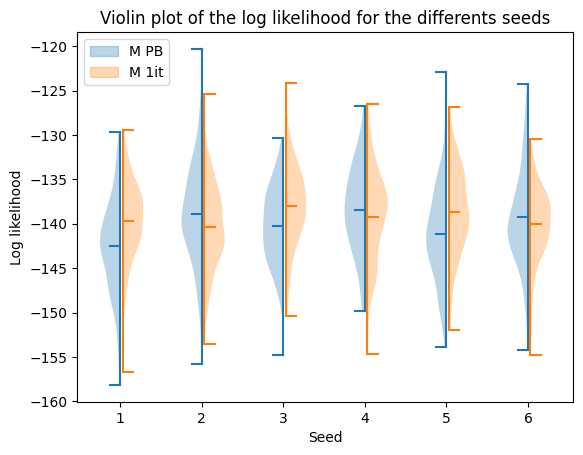

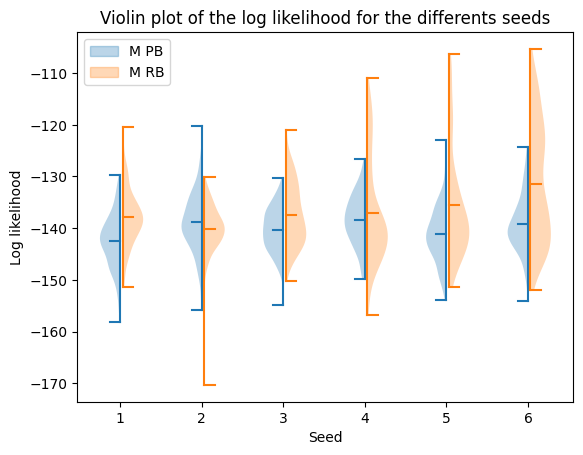

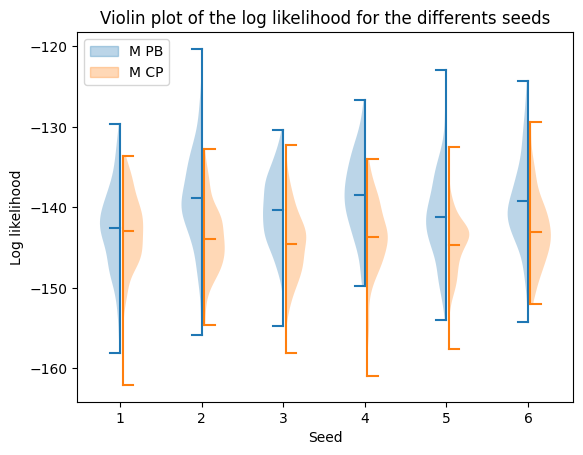

In [5]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
for b_name in all_baselines_name[1:]:
    plt.figure()
    color1 = plt.violinplot(all_likelihoods[all_baselines_name[0]].transpose(), showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
    color1 = matplotlib.patches.Patch(color=color1)
    color2 = plt.violinplot(all_likelihoods[b_name].transpose(), showmeans=True, side="high", positions=[i+1.03 for i in range(len(all_likelihoods[b_name]))])["bodies"][0].get_facecolor().flatten()
    color2 = matplotlib.patches.Patch(color=color2)
    plt.legend([color1, color2], [all_baselines_name[0], b_name])
    plt.title("Violin plot of the log likelihood for the differents seeds")
    plt.xlabel("Seed")
    plt.ylabel("Log likelihood")
    plt.show()

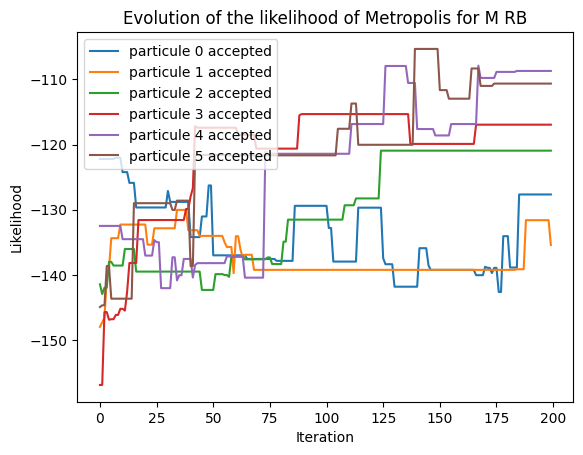

In [6]:
# Plot the evolution of the likelihood for the accepted rules
baseline_name = "M RB"
plt.figure()
for seed in range(all_rules[baseline_name].shape[0]):
    plt.plot(all_likelihoods[baseline_name][seed,all_additional_data[baseline_name]["prev_rules_ind"][seed,1:]], label="particule "+ str(seed)+" accepted")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.legend()
plt.title(f"Evolution of the likelihood of Metropolis for {baseline_name}")
plt.show()


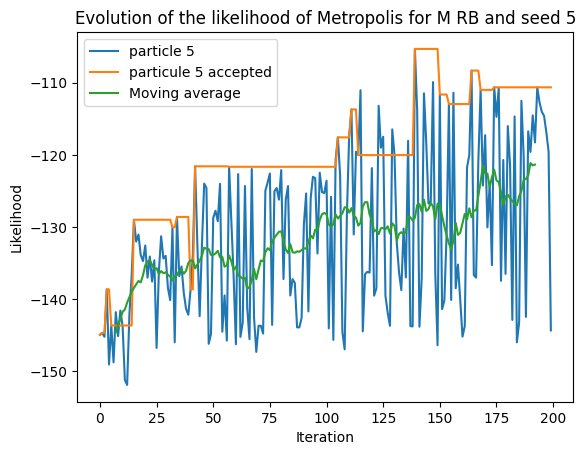

In [7]:
seed = 5
plt.figure()
plt.plot(all_likelihoods[baseline_name][seed, :-1], label="particle "+ str(seed))
plt.plot(all_likelihoods[baseline_name][seed,all_additional_data[baseline_name]["prev_rules_ind"][seed,1:]], label="particule "+ str(seed)+" accepted")

#Plot moving average of the likelihood
window_size = 15
moving_average = np.convolve(all_likelihoods[baseline_name][seed, :-1], np.ones(window_size)/window_size, mode='valid')
plt.plot(np.arange(window_size//2, len(moving_average)+window_size//2), moving_average, label="Moving average")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.legend()
plt.title(f"Evolution of the likelihood of Metropolis for {baseline_name} and seed " + str(seed))
plt.show()

# Embeddings

In [8]:
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(np.concatenate([all_rules[b_name].flatten() for b_name in all_baselines_name], axis=0))

### t-SNE

In [9]:
#Compute the t-SNE embeddings
proj_embeddings = TSNE(n_components=2).fit_transform(embeddings)

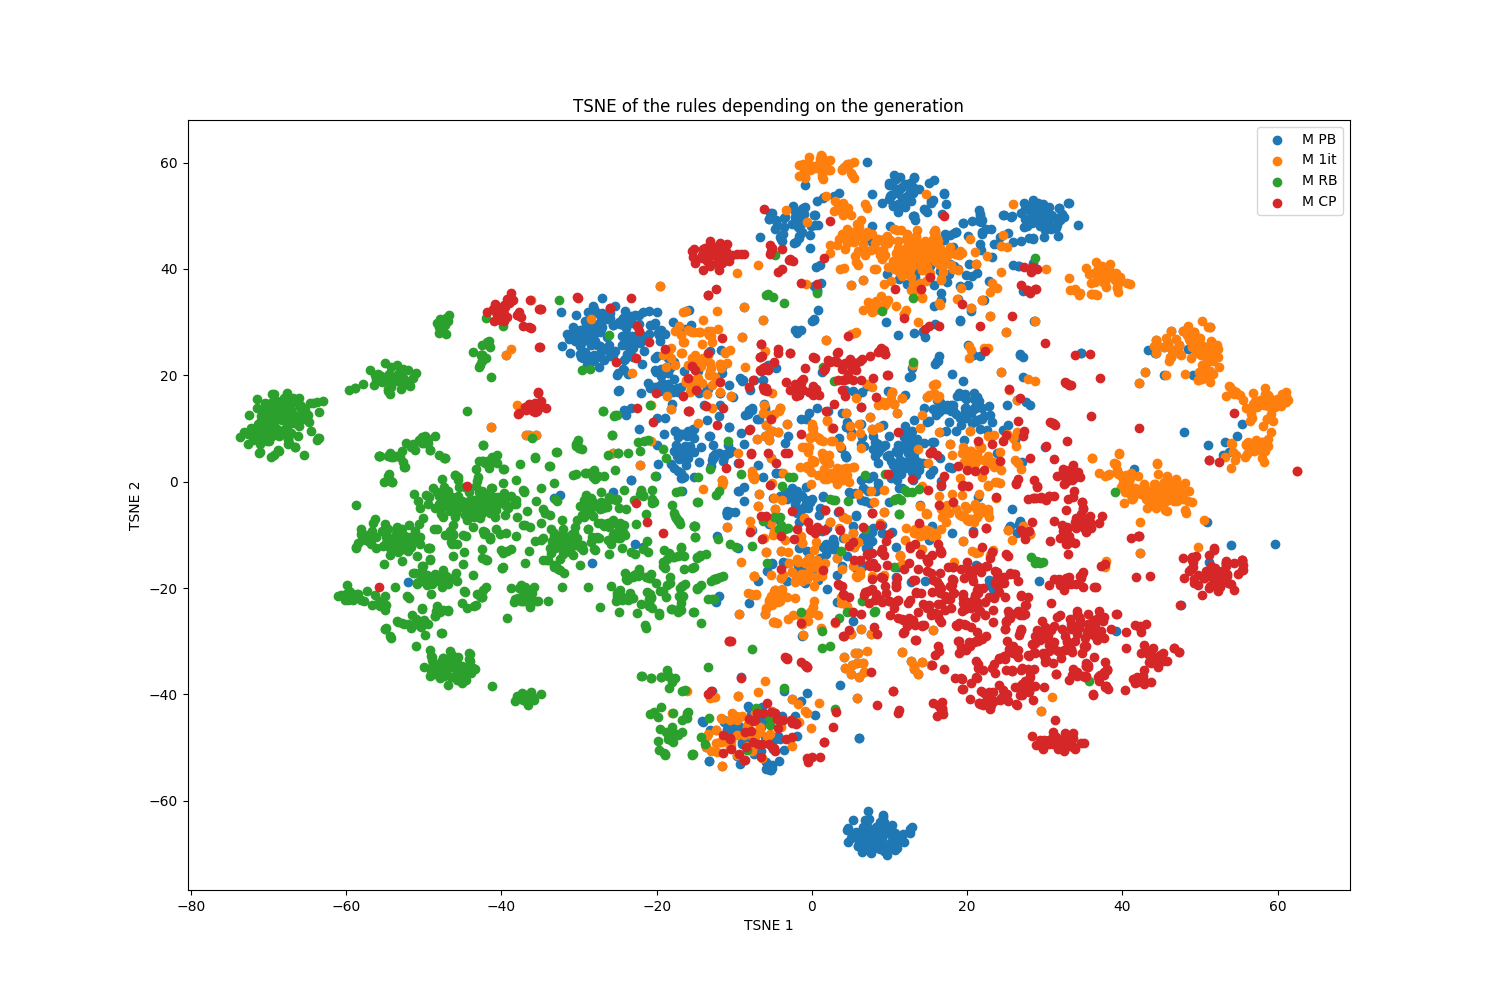

In [10]:
# Enable interactive backend
%matplotlib widget

# Plot the embeddings
plt.figure(figsize=(15,10))
rules = np.concatenate([all_rules[b_name].flatten() for b_name in all_baselines_name], axis=0)
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    plt.scatter(proj_embeddings[start_index:start_index+len(all_rules[b_name].flatten()),0], proj_embeddings[start_index:start_index+len(all_rules[b_name].flatten()),1], label=b_name)
    start_index = start_index + len(all_rules[b_name].flatten())
    
# Add interactive cursor
cursor = mplcursors.cursor(hover=True)
# Define the hover function
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=f"Rule: {(rules[sel.index])}")
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

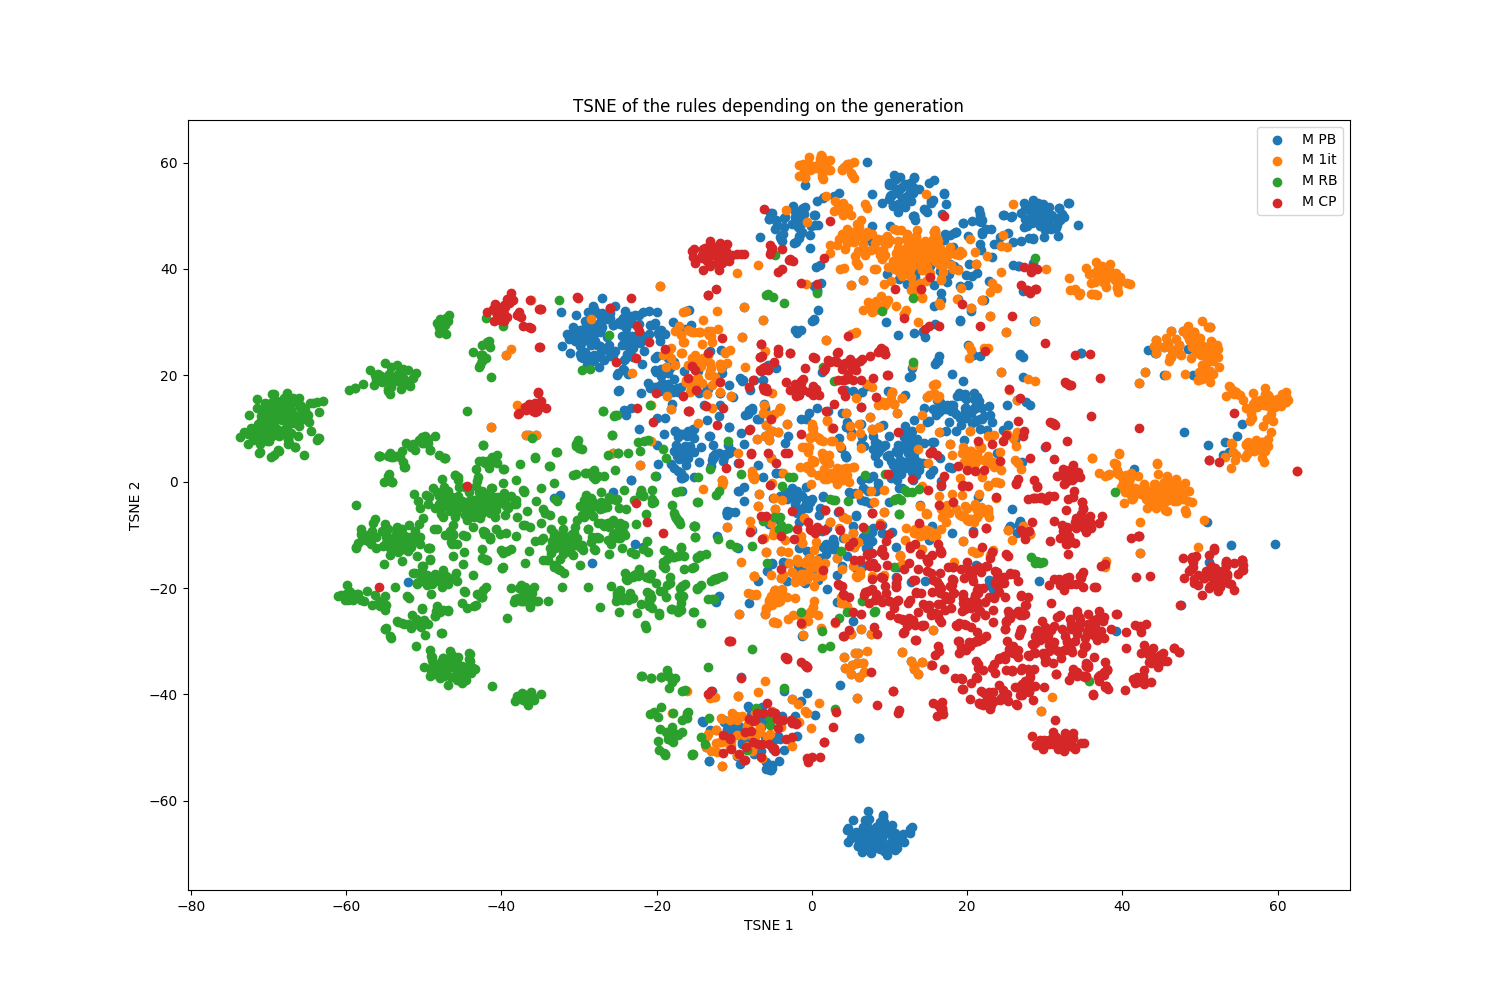

In [11]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
plt.figure(figsize=(15,10))
likelihoods = np.concatenate([all_likelihoods[b_name].flatten() for b_name in all_baselines_name])
mask_likelihood = likelihoods > -220
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    mask_index = (np.arange(len(likelihoods))<start_index+len(all_rules[b_name].flatten())) & (np.arange(len(likelihoods))>=start_index)
    plt.scatter(proj_embeddings[mask_index & mask_likelihood,0], proj_embeddings[mask_index & mask_likelihood,1], label=b_name)
    start_index = start_index + len(all_rules[b_name].flatten())
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

### PCA

In [12]:
#Compute the PCA embeddings
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj_embeddings = pca.fit_transform(embeddings)

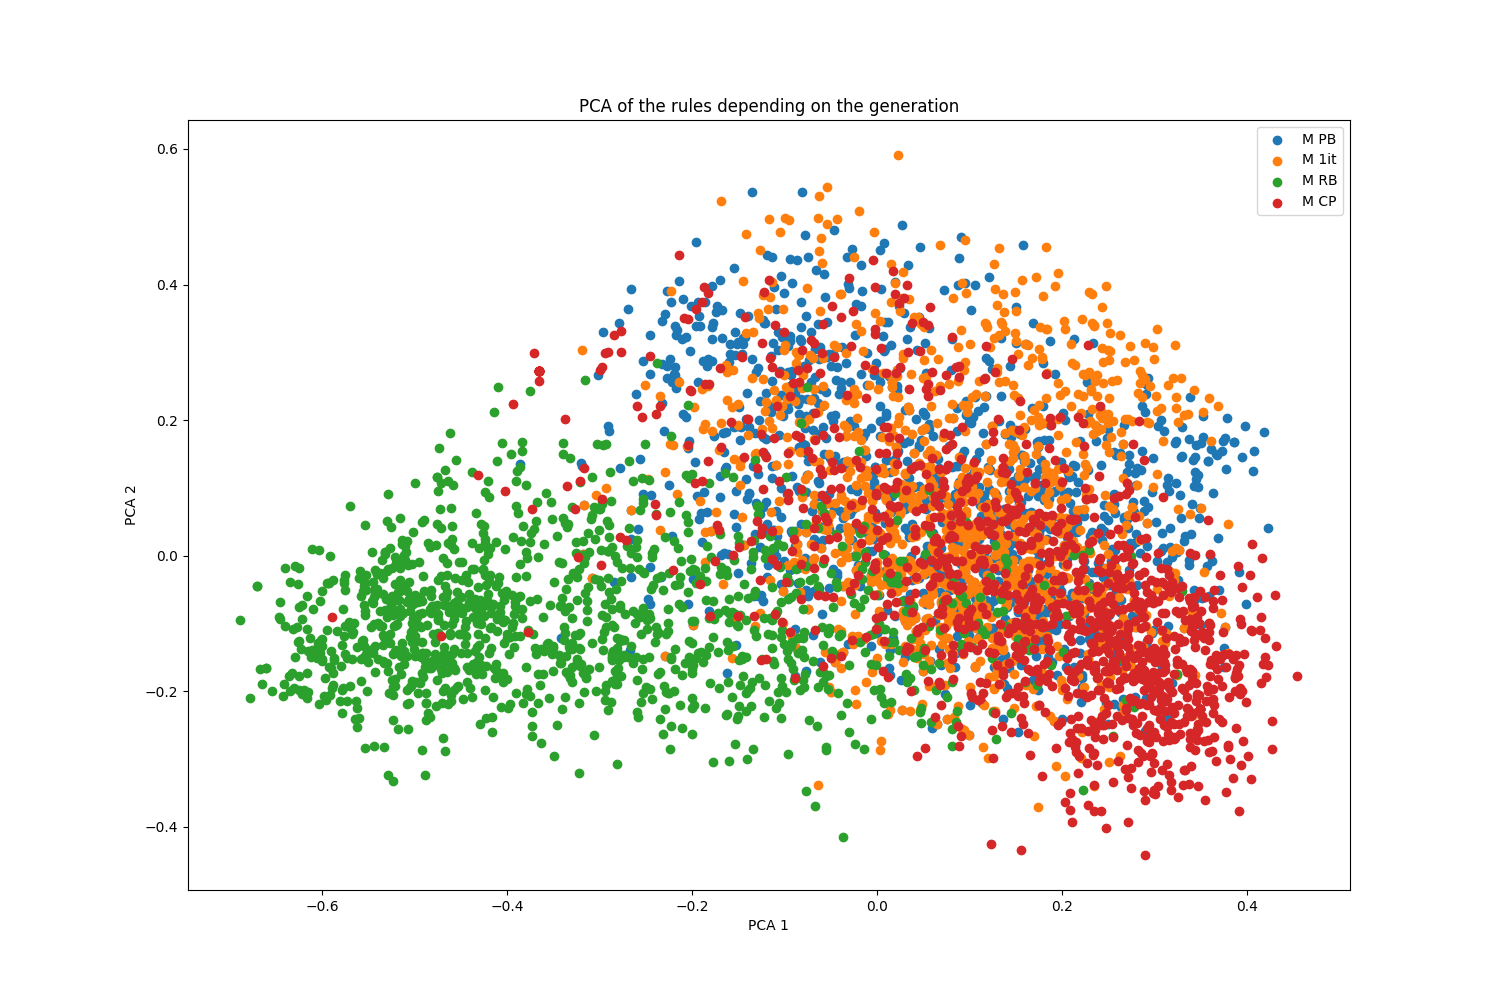

In [13]:
# Enable interactive backend
%matplotlib widget

# Plot the embeddings
plt.figure(figsize=(15,10))
rules = np.concatenate([all_rules[b_name].flatten() for b_name in all_baselines_name], axis=0)
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    plt.scatter(proj_embeddings[start_index:start_index+len(all_rules[b_name].flatten()),0], proj_embeddings[start_index:start_index+len(all_rules[b_name].flatten()),1], label=b_name)
    start_index = start_index + len(all_rules[b_name].flatten())
    
# Add interactive cursor
cursor = mplcursors.cursor(hover=True)
# Define the hover function
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=f"Rule: {(rules[sel.index])}")
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of the rules depending on the generation")
plt.show()

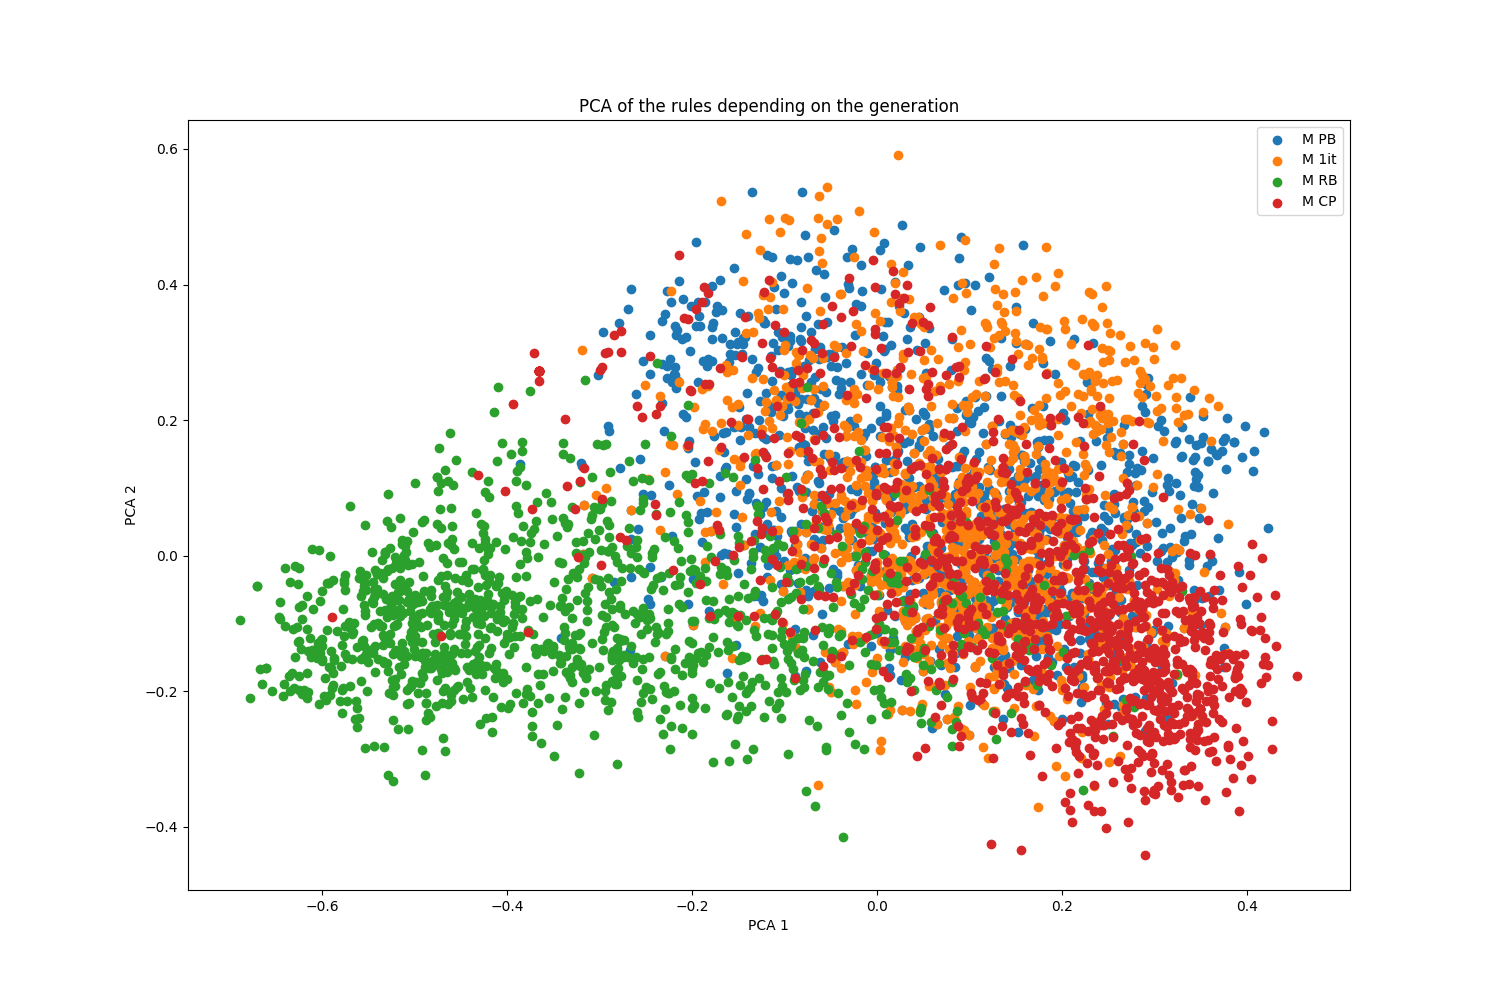

In [14]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
plt.figure(figsize=(15,10))
likelihoods = np.concatenate([all_likelihoods[b_name].flatten() for b_name in all_baselines_name])
mask_likelihood = likelihoods > -220
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    mask_index = (np.arange(len(likelihoods))<start_index+len(all_rules[b_name].flatten())) & (np.arange(len(likelihoods))>=start_index)
    plt.scatter(proj_embeddings[mask_index & mask_likelihood,0], proj_embeddings[mask_index & mask_likelihood,1], label=b_name)
    start_index = start_index + len(all_rules[b_name].flatten())
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of the rules depending on the generation")
plt.show()